# Enhanced Skin Cancer Detection Using Diffusion-Based Data Augmentation and Vision Transformers

# Installing Libraries

In [ ]:
# %pip uninstall -y torch torchvision
# %pip install torch==2.5.0 torchvision==0.20.0
# %pip install evaluate
# %pip install wandb
# %pip install huggingface_hub
# %pip install torch==2.5.0 torchvision==0.20.0 --index-url https://download.pytorch.org/whl/cu121

In [1]:
import pandas as pd
import os
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments

import wandb

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

### Load Training and Testing Data

In [1]:
from datasets import load_dataset, DatasetDict

dataset = load_dataset('TobanDjan/isic_full')

c:\Users\win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 8103/8103 [00:53<00:00, 150.53 examples/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['isic_id', 'target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'PRO

In [4]:
dataset['train'][0]

{'isic_id': 'ISIC_0074374',
 'target': 0.0,
 'patient_id': 'IP_8275247',
 'age_approx': 45.0,
 'sex': 'female',
 'anatom_site_general': 'lower extremity',
 'clin_size_long_diam_mm': 5.81,
 'image_type': 'TBP tile: close-up',
 'tbp_tile_type': '3D: XP',
 'tbp_lv_A': 19.3092,
 'tbp_lv_Aext': 11.28295,
 'tbp_lv_B': 28.71941,
 'tbp_lv_Bext': 28.06602,
 'tbp_lv_C': 34.60708,
 'tbp_lv_Cext': 30.24907,
 'tbp_lv_H': 56.0855,
 'tbp_lv_Hext': 68.09915,
 'tbp_lv_L': 36.10392,
 'tbp_lv_Lext': 52.10398,
 'tbp_lv_areaMM2': 20.84819,
 'tbp_lv_area_perim_ratio': 14.85512,
 'tbp_lv_color_std_mean': 2.971028,
 'tbp_lv_deltaA': 8.02625,
 'tbp_lv_deltaB': 0.6533947,
 'tbp_lv_deltaL': -16.00006,
 'tbp_lv_deltaLB': 16.19029,
 'tbp_lv_deltaLBnorm': 13.08323,
 'tbp_lv_eccentricity': 0.6521911,
 'tbp_lv_location': 'Left Leg - Lower',
 'tbp_lv_location_simple': 'Left Leg',
 'tbp_lv_minorAxisMM': 4.493151,
 'tbp_lv_nevi_confidence': 99.76054,
 'tbp_lv_norm_border': 1.370506,
 'tbp_lv_norm_color': 8.730084,
 'tbp

In [ ]:
dataset = dataset.remove_columns(['target', 'patient_id', 'age_approx', 'sex', 'anatom_site_general', 'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'attribution', 'copyright_license', 'lesion_id', 'iddx_full', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'PROC_use', 'PROC_source', 'diagnosis', 'PROC_diag_inferred', 'acquisition_day', 'concomitant_biopsy', 'dermoscopic_type', 'diagnosis_confirm_type', 'family_hx_mm', 'fitzpatrick_skin_type', 'mel_class', 'mel_type', 'mel_ulcer', 'melanocytic', 'nevus_type', 'personal_hx_mm', 'pixels_x', 'pixels_y', 'PROC_label_inferred'])

ValueError: Column name ['sex', 'diagnosis', 'patient_id', 'iddx_full', 'tbp_lv_dnn_lesion_confidence', 'concomitant_biopsy', 'tbp_lv_radial_color_std_max', 'PROC_diag_inferred', 'mel_type', 'personal_hx_mm', 'tbp_lv_deltaLBnorm', 'nevus_type', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM', 'mel_mitotic_index', 'PROC_label_inferred', 'copyright_license', 'fitzpatrick_skin_type', 'clin_size_long_diam_mm', 'tbp_lv_nevi_confidence', 'iddx_4', 'iddx_5', 'tbp_lv_symm_2axis_angle', 'tbp_lv_deltaL', 'tbp_lv_stdLExt', 'tbp_lv_z', 'tbp_lv_y', 'dermoscopic_type', 'tbp_lv_area_perim_ratio', 'mel_ulcer', 'tbp_lv_location', 'mel_thick_mm', 'tbp_lv_Lext', 'attribution', 'tbp_lv_symm_2axis', 'family_hx_mm', 'pixels_y', 'acquisition_day', 'pixels_x', 'PROC_source', 'tbp_lv_location_simple', 'tbp_lv_x', 'iddx_3', 'tbp_lv_C', 'tbp_lv_deltaB', 'tbp_lv_perimeterMM', 'PROC_use', 'tbp_lv_color_std_mean', 'diagnosis_confirm_type', 'tbp_lv_norm_border', 'iddx_2', 'tbp_lv_B', 'tbp_lv_L', 'tbp_lv_A', 'anatom_site_general', 'target', 'tbp_lv_stdL', 'tbp_lv_areaMM2', 'tbp_lv_deltaLB', 'age_approx', 'lesion_id', 'tbp_lv_Cext', 'image_type', 'tbp_tile_type', 'tbp_lv_deltaA', 'tbp_lv_Hext', 'iddx_1', 'tbp_lv_norm_color', 'melanocytic', 'mel_class', 'tbp_lv_Aext', 'tbp_lv_Bext', 'tbp_lv_H'] not in the dataset. Current columns in the dataset: ['isic_id', 'benign_malignant', 'label', 'image']

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['isic_id', 'benign_malignant', 'label', 'image'],
        num_rows: 71422
    })
    validation: Dataset({
        features: ['isic_id', 'benign_malignant', 'label', 'image'],
        num_rows: 9753
    })
    test: Dataset({
        features: ['isic_id', 'benign_malignant', 'label', 'image'],
        num_rows: 8103
    })
})

In [10]:
def count_benign_malignant(dataset, label_column='benign_malignant', id_column='isic_id'):
    # Initialize counters for benign and malignant
    benign_count = 0
    malignant_count = 0
    
    # List to store invalid isic_ids
    invalid_isic_ids = []

    # Iterate over the dataset
    for row in dataset:
        label = row[label_column]
        
        # Count benign and malignant
        if label == 'benign':
            benign_count += 1
        elif label == 'malignant':
            malignant_count += 1
        else:
            # If the label is neither 'benign' nor 'malignant', save the isic_id
            invalid_isic_ids.append(row[id_column])
    
    # Print the results
    print(f"Benign count: {benign_count}")
    print(f"Malignant count: {malignant_count}")
    print(f"Invalid isic_ids: {invalid_isic_ids}")

# Example usage
count_benign_malignant(dataset['test'])

Benign count: 6423
Malignant count: 873
Invalid isic_ids: ['ISIC_5490257', 'ISIC_0435215', 'ISIC_9569039', 'ISIC_6327722', 'ISIC_3182805', 'ISIC_6551901', 'ISIC_7980127', 'ISIC_0073228', 'ISIC_0073224', 'ISIC_0073137', 'ISIC_0073110', 'ISIC_0073081', 'ISIC_0073068', 'ISIC_0073066', 'ISIC_0073048', 'ISIC_0072932', 'ISIC_0072905', 'ISIC_0072830', 'ISIC_0072776', 'ISIC_0072761', 'ISIC_0072744', 'ISIC_0072709', 'ISIC_0072666', 'ISIC_0072658', 'ISIC_0072651', 'ISIC_0072625', 'ISIC_0072620', 'ISIC_0072616', 'ISIC_0072599', 'ISIC_0072515', 'ISIC_0072499', 'ISIC_0072479', 'ISIC_0072461', 'ISIC_0072450', 'ISIC_0072421', 'ISIC_0072370', 'ISIC_0072361', 'ISIC_0072359', 'ISIC_0072296', 'ISIC_0072262', 'ISIC_0072193', 'ISIC_0072075', 'ISIC_0072066', 'ISIC_0072058', 'ISIC_0072050', 'ISIC_0071912', 'ISIC_0071905', 'ISIC_0071885', 'ISIC_0071847', 'ISIC_0071843', 'ISIC_0071795', 'ISIC_0071709', 'ISIC_0071690', 'ISIC_0071672', 'ISIC_0071631', 'ISIC_0071565', 'ISIC_0071557', 'ISIC_0071466', 'ISIC_0071459

In [9]:
dataset["train"]

Dataset({
    features: ['isic_id', 'benign_malignant', 'label', 'image'],
    num_rows: 71422
})

In [18]:
train_iterable_dataset = dataset['train'].to_iterable_dataset()
test_iterable_dataset = dataset['test'].to_iterable_dataset()

In [21]:
from datasets import Dataset
import numpy as np

def count_samples(dataset):
    """Count malignant and benign samples without loading entire dataset."""
    counts = {"malignant": 0, "benign": 0}
    
    def count_batch(batch):
        counts["malignant"] += sum(1 for x in batch["benign_malignant"] if x == "malignant")
        counts["benign"] += sum(1 for x in batch["benign_malignant"] if x == "benign")
        return batch
    
    # Count in batches
    dataset.map(count_batch, batched=True, batch_size=1000)
    return counts

def create_balanced_dataset(dataset):
    """Creates balanced dataset processing in batches."""
    # First pass: count samples and collect malignant indices
    counts = {"malignant": 0, "benign": 0}
    malignant_indices = []
    
    def first_pass(batch, idx):
        for i, status in enumerate(batch["benign_malignant"]):
            if status == "malignant":
                counts["malignant"] += 1
                malignant_indices.append(idx * len(batch) + i)
            else:
                counts["benign"] += 1
        return batch
    
    # Process in batches
    dataset.map(first_pass, batched=True, batch_size=1000, with_indices=True)
    
    # Randomly sample benign indices
    rng = np.random.default_rng(42)
    n_samples = counts["malignant"]
    
    # Second pass: collect benign indices
    benign_indices = []
    current_benign = 0
    
    def second_pass(batch, idx):
        nonlocal current_benign
        for i, status in enumerate(batch["benign_malignant"]):
            if status == "benign":
                benign_indices.append(idx * len(batch) + i)
                current_benign += 1
        return batch
    
    dataset.map(second_pass, batched=True, batch_size=1000, with_indices=True)
    
    # Randomly sample from benign indices
    sampled_benign_indices = rng.choice(
        benign_indices, 
        size=n_samples, 
        replace=False
    ).tolist()
    
    # Combine indices and sort them
    final_indices = sorted(malignant_indices + sampled_benign_indices)
    
    # Create new dataset using selected indices
    return dataset.select(final_indices)

# Example usage:
# First check the counts
counts = count_samples(dataset['train'])
print(f"Original dataset counts: {counts}")



Map:  27%|██▋       | 19000/71422 [01:47<04:57, 176.43 examples/s]


OSError: [Errno 28] No space left on device

In [ ]:
# Then create balanced dataset
balanced_dataset = create_balanced_dataset(dataset)

In [12]:
malignant_samples

IterableDataset({
    features: ['isic_id', 'benign_malignant', 'label', 'image'],
    num_shards: 1
})

### Not Needed

In [ ]:
# #smote images
# def create_image_dataframe(base_dir):
#     image_ids = []
#     labels = []
#     file_paths = []

#     for label in ['0', '1']: 
#         label_dir = os.path.join(base_dir, label)
#         for image_name in os.listdir(label_dir):
#             if image_name.endswith(".jpg"): 
#                 image_id = image_name.split('.')[0]
#                 image_ids.append(image_id)
#                 labels.append(int(label))
#                 file_path = os.path.join(label_dir, image_name)
#                 file_paths.append(file_path)

#     df = pd.DataFrame({
#         'image_id': image_ids,
#         'label': labels,
#         'file_path': file_paths,
#     })
    
#     return df
# base_dir = 'datasets/ISIC2016/smote_images'
# #train_labels_df = create_image_dataframe(base_dir)

# #original images
# def process_dataset(csv_file, image_dir, label_map):
#     labels_df = pd.read_csv(csv_file, header=None, names=['image_id', 'label'])
#     labels_df['label'] = labels_df['label'].map(label_map)
#     labels_df['file_path'] = labels_df['image_id'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
    
#     return labels_df

# label_map_train = {'benign': 0, 'malignant': 1}
# label_map_test = {0.0: 0, 1.0: 1}

# train_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
# train_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Training_Data'

# test_csv_file = 'datasets/ISIC2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
# test_image_dir = 'datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Data'

# train_labels_df = process_dataset(train_csv_file, train_image_dir, label_map_train)
# test_labels_df = process_dataset(test_csv_file, test_image_dir, label_map_test)
# validation_labels_df, test_labels_df = train_test_split(test_labels_df, test_size=0.5, random_state=42)

# print(train_labels_df.head())
# print(test_labels_df.head())
# print(validation_labels_df.head())

       image_id  label                                          file_path
0  ISIC_0000000      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
1  ISIC_0000001      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
2  ISIC_0000002      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
3  ISIC_0000004      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
4  ISIC_0000006      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Training...
         image_id  label                                          file_path
288  ISIC_0010451      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
283  ISIC_0010379      1  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
327  ISIC_0011092      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
145  ISIC_0001685      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
55   ISIC_0000202      0  datasets/ISIC2016/ISBI2016_ISIC_Part1_Test_Dat...
         image_id  label                                          file_path
11   ISIC_0000040      1

### Dataset Characterization and Visualization

Train
Dataset has 2 classes and 900 samples.
Class counts:
0    727
1    173
Name: label, dtype: int64


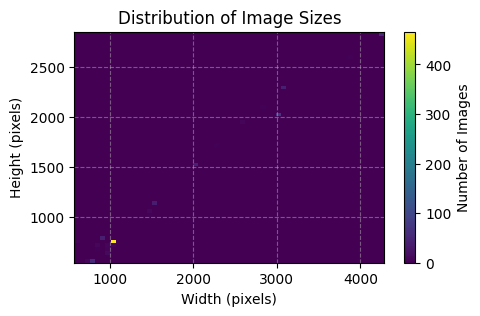

Validation
Dataset has 2 classes and 189 samples.
Class counts:
0    152
1     37
Name: label, dtype: int64


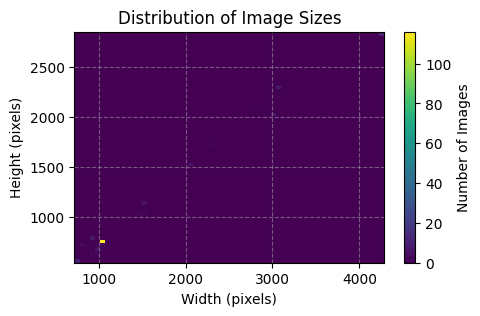

Test
Dataset has 2 classes and 190 samples.
Class counts:
0    152
1     38
Name: label, dtype: int64


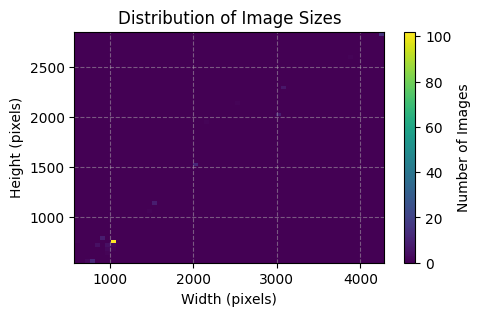

In [3]:
def characterize_dataset(labels_df):
        widths, heights = [], []
        class_counts = labels_df['label'].value_counts()
        
        for idx, row in labels_df.iterrows():
            image = Image.open(row['file_path'])
            widths.append(image.size[0])
            heights.append(image.size[1])
        
        print(f"Dataset has {len(class_counts)} classes and {len(labels_df)} samples.")
        print(f"Class counts:\n{class_counts}")
       
        plt.figure(figsize=(5, 3))
        plt.hist2d(widths, heights, bins=60, cmap='viridis')
        plt.colorbar(label='Number of Images')
        plt.title("Distribution of Image Sizes")
        plt.xlabel("Width (pixels)")
        plt.ylabel("Height (pixels)")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

print("Train")
characterize_dataset(train_labels_df)
print("Validation")
characterize_dataset(validation_labels_df)
print("Test")
characterize_dataset(test_labels_df)

### Plotting Samples


In [ ]:
def plot_samples(labels_df, rows=2, cols=5, processor=None):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    sampled_df = labels_df.sample(n=rows * cols, random_state=42)
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['file_path']
        label = row['label']
        
        image = Image.open(image_path).convert("RGB")
        
        if processor:
            image = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).permute(1, 2, 0).numpy()
        else:
            image = np.array(image)

        axes[i].imshow(image)
        axes[i].set_title('Malignant' if label == 1 else 'Benign')  # Set title based on the label
        axes[i].axis('off')  # Turn off axes
    plt.tight_layout()
    plt.show()

plot_samples(train_labels_df)
plot_samples(validation_labels_df)

# Classification using Vision Transformers

### Defining Dataset for ViT

In [ ]:
class ISICDatasetTransform(Dataset):
    def __init__(self, labels_df, processor=None):
        self.labels_df = labels_df
        self.processor = processor

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        image = Image.open(row['file_path']).convert("RGB")
        inputs = self.processor(images=image, return_tensors="pt")
        label = row['label']
        inputs['labels'] = torch.tensor(label)
        
        return inputs

### Loading Model and Processor

In [ ]:
def load_model_and_processor(model_name):
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForImageClassification.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes = True
    )
    for name,p in model.named_parameters():
        if not name.startswith('classifier'):
            p.requires_grad = False

    num_params = sum([p.numel() for p in model.parameters()])
    trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])

    print(f"{num_params = :,} | {trainable_params = :,}")

    return model, processor

### Data Collator Function

In [ ]:
def collate_fn(batch):
    pixel_values = torch.stack([x['pixel_values'].squeeze(0) for x in batch])
    labels = torch.tensor([x['labels'] for x in batch])
    
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

### Metric Computation for Evaluation

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, average_precision_score, roc_auc_score, accuracy_score

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, axis=1).numpy()  # Get predicted classes
    probabilities = torch.softmax(logits, dim=1)[:, 1].numpy()  # Probabilities for class 1

    # Accuracy
    accuracy_score_value = accuracy_score(labels, predictions)
    
    # Sensitivity (Recall for positive class)
    sensitivity_score = recall_score(labels, predictions, pos_label=1)
    
    # Specificity
    tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
    specificity_score = tn / (tn + fp)
    
    # Average Precision
    avg_precision = average_precision_score(labels, probabilities)
    
    # AUC-ROC
    auc_score = roc_auc_score(labels, probabilities)

    wandb.log({
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    })
    
    return {
        'accuracy': accuracy_score_value,
        'sensitivity': sensitivity_score,
        'specificity': specificity_score,
        'average_precision': avg_precision,
        'auc_roc': auc_score
    }

## Model Training and Evaluation

### Ready Results

In [ ]:
import json
output_file = './output/model_comparison.json'
try:
    with open(output_file, 'r') as f:
        results = json.load(f)
except FileNotFoundError:
    results = {}

### Training Loop

In [ ]:
wandb.init(project='skin_cancer_detection')
model_names = ["google/vit-base-patch16-224"] # "google/vit-large-patch16-224", "google/vit-base-patch16-384"

for model_name in model_names:
    # Load model and processor
    model, processor = load_model_and_processor(model_name)
    
    # Prepare dataset with processor's transformations
    train_dataset = ISICDatasetTransform(train_labels_df, processor)
    eval_dataset = ISICDatasetTransform(validation_labels_df, processor)
    test_dataset = ISICDatasetTransform(test_labels_df, processor)

    # Define Training Arguments
    training_args = TrainingArguments(
        output_dir=f'./results/{model_name}',
        per_device_train_batch_size=16,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_steps=100,
        num_train_epochs=5,
        learning_rate=3e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        push_to_hub=True,
        report_to='wandb',
        load_best_model_at_end=True,
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=processor,
    )

    # Train and evaluate
    print(f"Training and evaluating model: {model_name}")
    trainer.train(resume_from_checkpoint=False) # Set to True to resume training
    eval_results = trainer.evaluate(test_dataset)
    results[model_name] = eval_results

In [ ]:
wandb.finish()

### Results for Comparison

In [ ]:
# Print out the results for comparison
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")
    print("\n")


# Save the results in JSON format
with open(output_file, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Results saved to {output_file}")